FIXED: BATTERY PLATING DETECTION WITH REALISTIC ICA
Generating 200 battery simulations...
  Progress: 50/200
  Progress: 100/200
  Progress: 150/200
  Progress: 200/200
Dataset built: 200 samples, 32 features
Plating cases: 66 (33.0%)
   ica_mean   ica_std  ica_skew  ica_kurt   ica_max   ica_min  ica_range  \
0  2.271259  0.493745  0.497621  1.672106  4.661690  1.031691   3.629999   
1  2.235488  0.476264  0.573410  1.145252  4.004537  1.180136   2.824401   
2  2.254287  0.437098  0.193419  1.701266  4.170966  1.065399   3.105567   
3  2.217915  0.476407  0.663505  2.251701  4.571898  1.174366   3.397532   
4  2.270866  0.472348  0.157661  0.075620  3.792119  1.236416   2.555703   

   peak_count_total  peak_count_pos  max_peak_height  ...    v_mean     v_std  \
0                17              17         4.661690  ...  3.646039  0.310688   
1                20              20         4.004537  ...  3.644239  0.314638   
2                15              15         4.170966  ...  3.6581

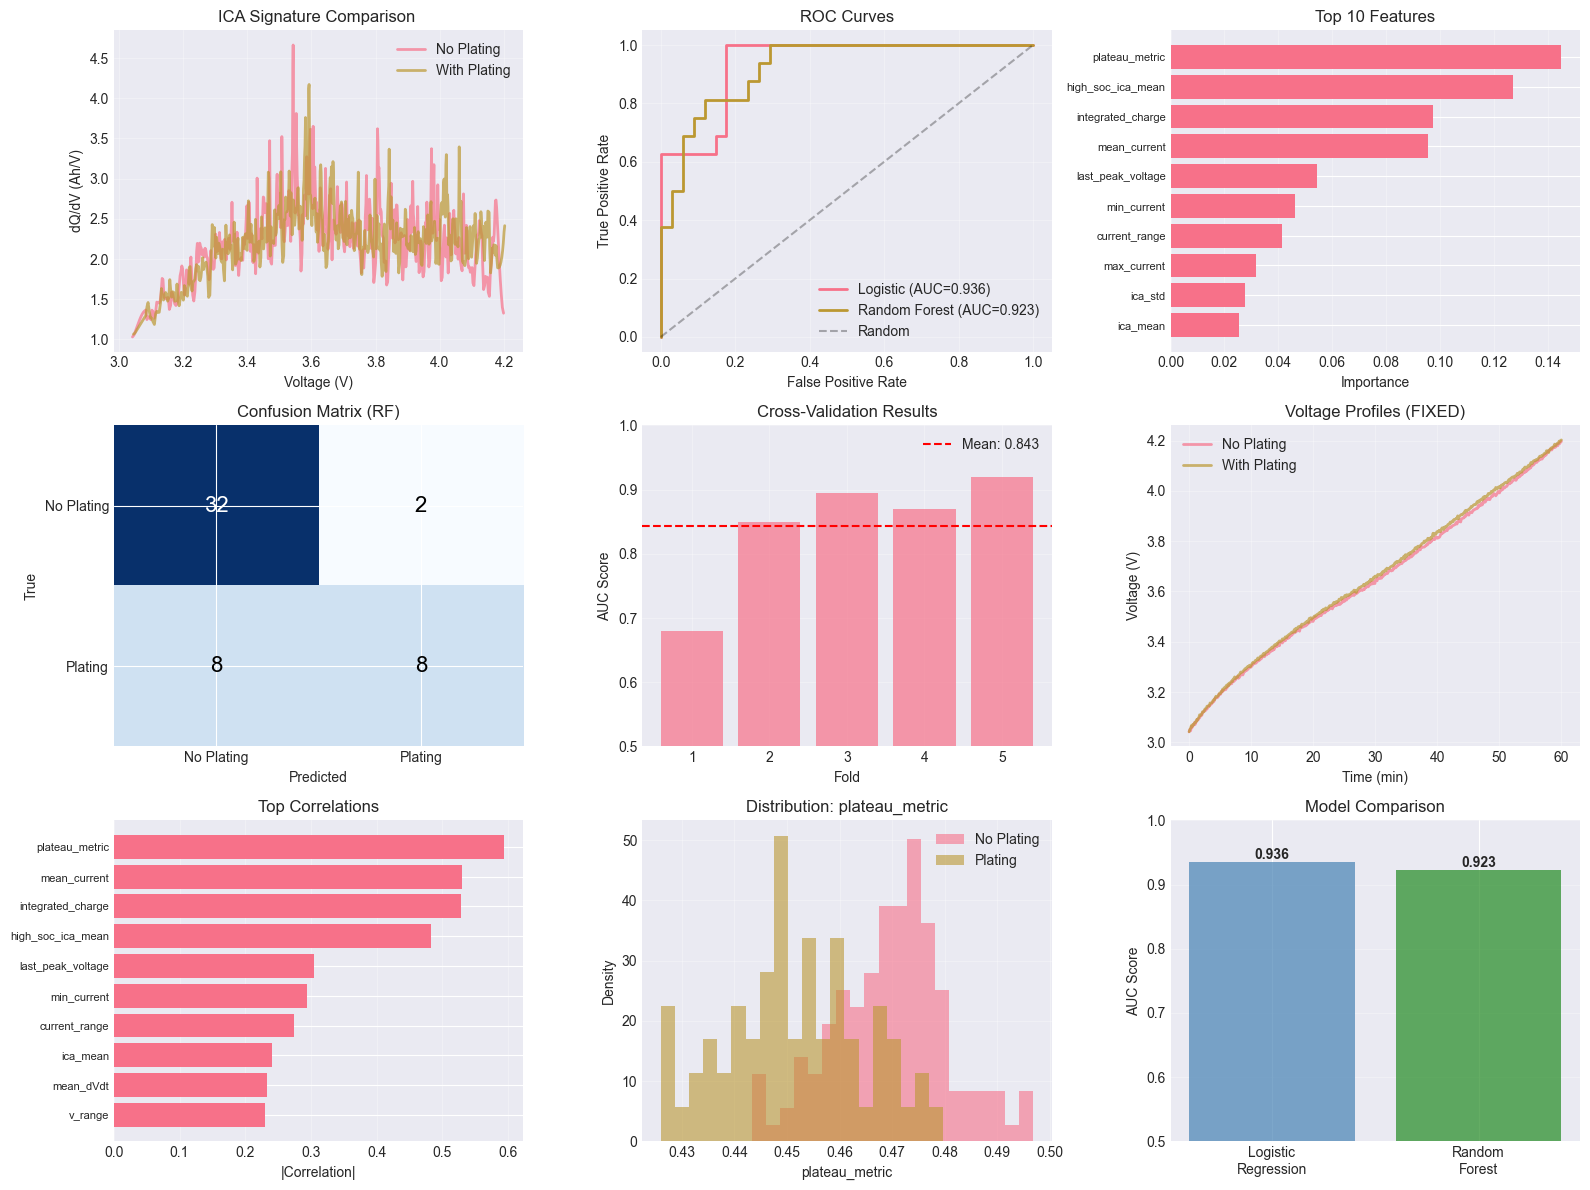


COMPLETE! 


In [11]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, find_peaks
from scipy import integrate
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve, mean_squared_error)
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION ====================
SAVGOL_WINDOW = 21
SAVGOL_POLY = 3
PEAK_PERCENTILE = 85
N_ESTIMATORS = 200
MAX_DEPTH = 8
RANDOM_STATE = 42

# ==================== DATA GENERATION (FIXED) ====================
def generate_pybamm_simulation(sim_id, mode='charge'):
    """
    Generate realistic battery charge/discharge data with MONOTONIC voltage profile.
    Fixed: Removed oscillating sine term for realistic ICA analysis.
    """
    np.random.seed(sim_id)
    
    # Time array (0-3600 seconds = 1 hour charge)
    n_points = 500
    time = np.linspace(0, 3600, n_points)
    
    # Base parameters with realistic variation
    nominal_voltage = 3.7 + np.random.normal(0, 0.05)
    min_voltage = 3.0
    max_voltage = 4.2 + np.random.normal(0, 0.02)
    capacity_nominal = 2.5  # Ah
    
    # Generate capacity profile (Ah)
    if mode == 'charge':
        Q = np.linspace(0, capacity_nominal, n_points)
        # Current profile (CC-CV charging)
        current = np.ones(n_points) * 1.0  # 1C rate
        current[Q > 0.8*capacity_nominal] *= np.exp(-2*(Q[Q > 0.8*capacity_nominal] - 0.8*capacity_nominal))
    else:
        Q = np.linspace(capacity_nominal, 0, n_points)
        current = -np.ones(n_points) * 1.0
    
    # FIXED: Realistic voltage profile with smooth monotonic increase
    soc = Q / capacity_nominal
    
    # Realistic OCV curve for NMC/Graphite (smooth, monotonic)
    # Uses multiple smooth components to create realistic phase transitions
    ocv = min_voltage + (max_voltage - min_voltage) * (
        0.3 * soc +                           # Linear component
        0.4 * soc**2 +                        # Quadratic rise
        0.3 * (1 - np.exp(-5*soc))           # Exponential saturation at high SOC
    )
    
    # Add smooth phase transition features (pseudo-OCV plateaus)
    # These create realistic ICA peaks without oscillations
    phase1 = 0.02 * np.exp(-50*(soc - 0.2)**2)  # Small feature around 20% SOC
    phase2 = 0.03 * np.exp(-30*(soc - 0.5)**2)  # Medium feature around 50% SOC
    phase3 = 0.02 * np.exp(-40*(soc - 0.8)**2)  # Small feature around 80% SOC
    
    ocv = ocv - phase1 - phase2 - phase3
    
    # Add realistic overpotential (IR drop)
    resistance = 0.05 + np.random.normal(0, 0.005)
    overpotential = resistance * np.abs(current)
    
    if mode == 'charge':
        voltage = ocv + overpotential
    else:
        voltage = ocv - overpotential
    
    # Determine if plating occurs
    plating_risk = (sim_id % 3 == 0)  # 33% plating cases
    plating_severity = np.random.uniform(0.01, 0.15) if plating_risk else 0.0
    
    plated_capacity = 0.0
    
    if plating_risk and mode == 'charge':
        # Plating effects: voltage plateau/dip at high SOC
        plating_onset_idx = int(0.75 * n_points)  # Starts at 75% SOC
        plating_factor = np.zeros(n_points)
        plating_factor[plating_onset_idx:] = plating_severity * np.linspace(0, 1, 
                                                          n_points - plating_onset_idx)**2
        
        # Voltage plateau/dip (characteristic plating signature)
        voltage[plating_onset_idx:] -= plating_factor[plating_onset_idx:] * 0.15
        
        # Calculate plated capacity
        plated_capacity = plating_severity * capacity_nominal
        
        # Modify current (increased resistance due to plating)
        current[plating_onset_idx:] *= (1 - 0.15 * plating_factor[plating_onset_idx:])
    
    # Add realistic measurement noise (small!)
    voltage += np.random.normal(0, 0.003, n_points)
    current += np.random.normal(0, 0.008, n_points)
    
    # Clip to physical limits
    voltage = np.clip(voltage, 2.8, 4.3)
    
    return {
        'time': time,
        'voltage': voltage,
        'current': current,
        'Q': Q,
        'plated_capacity': plated_capacity,
        'label': int(plating_risk)
    }

# ==================== FEATURE EXTRACTION ====================
def extract_comprehensive_features(sim):
    """Extract rich feature set combining ICA, statistical, and electrochemical features."""
    time = np.array(sim['time'])
    V = np.array(sim['voltage'])
    I = np.array(sim['current'])
    Q = np.array(sim['Q'])
    label = sim.get('label', 0)
    plated_final = sim.get('plated_capacity', 0.0)
    
    # Validate data
    if len(Q) < 20 or len(V) < 20:
        return None
    
    # Smooth data
    window = min(SAVGOL_WINDOW, len(V)//2*2 - 1) if len(V) % 2 == 0 else min(SAVGOL_WINDOW, len(V)//2*2 + 1)
    window = max(5, window)
    
    try:
        V_smooth = savgol_filter(V, window, SAVGOL_POLY)
        Q_smooth = savgol_filter(Q, window, SAVGOL_POLY)
    except:
        V_smooth = V
        Q_smooth = Q
    
    # Incremental Capacity Analysis (dQ/dV)
    dV = np.gradient(V_smooth)
    dQ = np.gradient(Q_smooth)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        dQdV = np.where(np.abs(dV) > 1e-9, dQ / dV, 0.0)
    
    # Remove outliers
    dQdV_clean = dQdV[np.isfinite(dQdV)]
    if len(dQdV_clean) == 0:
        return None
    
    # ICA statistics
    ica_mean = np.mean(dQdV_clean)
    ica_std = np.std(dQdV_clean)
    ica_skew = pd.Series(dQdV_clean).skew()
    ica_kurt = pd.Series(dQdV_clean).kurtosis()
    ica_max = np.max(dQdV_clean)
    ica_min = np.min(dQdV_clean)
    
    # Peak Detection
    threshold = np.nanpercentile(np.abs(dQdV_clean), PEAK_PERCENTILE)
    peaks_pos, props_pos = find_peaks(dQdV_clean, height=threshold, distance=10)
    peaks_neg, props_neg = find_peaks(-dQdV_clean, height=threshold, distance=10)
    
    peak_count_pos = len(peaks_pos)
    peak_count_neg = len(peaks_neg)
    peak_count_total = peak_count_pos + peak_count_neg
    
    # Peak heights
    heights_pos = props_pos['peak_heights'] if peak_count_pos > 0 else np.array([0])
    max_peak_pos = np.max(heights_pos)
    mean_peak_pos = np.mean(heights_pos)
    
    # Peak voltage locations
    peak_voltages = V_smooth[peaks_pos] if peak_count_pos > 0 else np.array([np.nan])
    first_peak_voltage = peak_voltages[0] if len(peak_voltages) > 0 else np.nan
    last_peak_voltage = peak_voltages[-1] if len(peak_voltages) > 0 else np.nan
    
    # Low voltage anomaly (plating signature)
    low_v_threshold = np.percentile(V_smooth, 20)
    low_v_mask = V_smooth < low_v_threshold
    low_v_ica = np.max(np.abs(dQdV_clean[low_v_mask])) if np.any(low_v_mask) else 0.0
    
    # High SOC features (plating typically at high SOC)
    high_soc_idx = int(0.75 * len(V))
    high_soc_ica_mean = np.mean(dQdV_clean[high_soc_idx:]) if high_soc_idx < len(dQdV_clean) else 0
    high_soc_ica_std = np.std(dQdV_clean[high_soc_idx:]) if high_soc_idx < len(dQdV_clean) else 0
    
    # Voltage plateau detection (plating signature)
    dVdQ = np.gradient(V_smooth, Q_smooth)
    plateau_metric = np.mean(np.abs(dVdQ[high_soc_idx:]))  # Low dV/dQ = plateau
    
    # Current Features
    max_current = np.max(np.abs(I))
    min_current = np.min(I)
    mean_current = np.mean(I)
    current_range = np.max(I) - np.min(I)
    integrated_charge = np.trapz(np.abs(I), time)
    
    # Voltage Features
    v_mean = np.mean(V_smooth)
    v_std = np.std(V_smooth)
    v_range = np.max(V_smooth) - np.min(V_smooth)
    
    # Voltage derivative
    dVdt = np.gradient(V_smooth, time)
    max_dVdt = np.max(dVdt)
    min_dVdt = np.min(dVdt)
    mean_dVdt = np.mean(np.abs(dVdt))
    
    # Time Features
    total_time = time[-1] - time[0]
    total_capacity = np.max(Q) - np.min(Q)
    
    features = {
        'ica_mean': float(ica_mean),
        'ica_std': float(ica_std),
        'ica_skew': float(ica_skew),
        'ica_kurt': float(ica_kurt),
        'ica_max': float(ica_max),
        'ica_min': float(ica_min),
        'ica_range': float(ica_max - ica_min),
        'peak_count_total': int(peak_count_total),
        'peak_count_pos': int(peak_count_pos),
        'max_peak_height': float(max_peak_pos),
        'mean_peak_height': float(mean_peak_pos),
        'first_peak_voltage': float(first_peak_voltage),
        'last_peak_voltage': float(last_peak_voltage),
        'low_v_ica_max': float(low_v_ica),
        'high_soc_ica_mean': float(high_soc_ica_mean),
        'high_soc_ica_std': float(high_soc_ica_std),
        'plateau_metric': float(plateau_metric),
        'max_current': float(max_current),
        'min_current': float(min_current),
        'mean_current': float(mean_current),
        'current_range': float(current_range),
        'integrated_charge': float(integrated_charge),
        'v_mean': float(v_mean),
        'v_std': float(v_std),
        'v_range': float(v_range),
        'max_dVdt': float(max_dVdt),
        'min_dVdt': float(min_dVdt),
        'mean_dVdt': float(mean_dVdt),
        'total_time': float(total_time),
        'total_capacity': float(total_capacity),
        'plated_capacity': float(plated_final),
        'label': int(label)
    }
    
    return features

# ==================== DATASET BUILDING ====================
def build_dataset(n_sims=200):
    """Generate dataset from simulations."""
    print(f"Generating {n_sims} battery simulations...")
    rows = []
    
    for i in range(1, n_sims + 1):
        if i % 50 == 0:
            print(f"  Progress: {i}/{n_sims}")
        
        sim = generate_pybamm_simulation(i, mode='charge')
        features = extract_comprehensive_features(sim)
        
        if features is not None:
            rows.append(features)
    
    df = pd.DataFrame(rows)
    print(f"Dataset built: {df.shape[0]} samples, {df.shape[1]} features")
    print(f"Plating cases: {df['label'].sum()} ({100*df['label'].mean():.1f}%)")
    print(df.head())
    return df
    

# ==================== MODEL TRAINING ====================
def train_models(df):
    """Train multiple models with cross-validation and comparison."""
    print("\n" + "="*60)
    print("TRAINING CLASSIFICATION MODELS")
    print("="*60)
    
    df_clean = df.dropna(subset=['label'])
    X = df_clean.drop(columns=['label', 'plated_capacity'])
    y = df_clean['label'].values
    X = X.fillna(X.mean())
    
    print(f"\nFeature count: {X.shape[1]}")
    print(f"Sample count: {X.shape[0]} (Plating: {y.sum()}, No plating: {len(y)-y.sum()})")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = {}
    
    # Logistic Regression
    print("\n[1] Logistic Regression")
    print("-" * 40)
    lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    lr.fit(X_train_scaled, y_train)
    
    y_pred_lr = lr.predict(X_test_scaled)
    y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
    
    auc_lr = roc_auc_score(y_test, y_proba_lr)
    print(f"AUC-ROC: {auc_lr:.4f}")
    print(classification_report(y_test, y_pred_lr, target_names=['No Plating', 'Plating']))
    
    results['lr'] = {'model': lr, 'auc': auc_lr, 'y_pred': y_pred_lr, 'y_proba': y_proba_lr}
    
    # Random Forest with CV
    print("\n[2] Random Forest Classifier")
    print("-" * 40)
    rf = RandomForestClassifier(
        n_estimators=N_ESTIMATORS,
        max_depth=MAX_DEPTH,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(rf, X_train, y_train, cv=skf, scoring='roc_auc')
    print(f"Cross-Validation AUC (5-fold): {cv_scores}")
    print(f"Mean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    rf.fit(X_train, y_train)
    
    y_pred_rf = rf.predict(X_test)
    y_proba_rf = rf.predict_proba(X_test)[:, 1]
    
    auc_rf = roc_auc_score(y_test, y_proba_rf)
    print(f"\nTest Set AUC-ROC: {auc_rf:.4f}")
    print(classification_report(y_test, y_pred_rf, target_names=['No Plating', 'Plating']))
    
    importances = rf.feature_importances_
    feat_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feat_imp.head(10).to_string(index=False))
    
    results['rf'] = {
        'model': rf,
        'auc': auc_rf,
        'cv_scores': cv_scores,
        'y_pred': y_pred_rf,
        'y_proba': y_proba_rf,
        'feature_importance': feat_imp
    }
    
    models_dict = {
        'scaler': scaler,
        'logistic': lr,
        'random_forest': rf,
        'feature_names': list(X.columns)
    }
    joblib.dump(models_dict, 'plating_detection_models.pkl')
    print("\n✓ Models saved to 'plating_detection_models.pkl'")
    
    return results, X_test, y_test, scaler

# ==================== VISUALIZATION ====================
def plot_comprehensive_results(df, results, X_test, y_test):
    """Create comprehensive visualization."""
    fig = plt.figure(figsize=(16, 12))
    
    # Plot 1: ICA Comparison
    ax1 = plt.subplot(3, 3, 1)
    sim_no_plating = generate_pybamm_simulation(1, mode='charge')
    sim_plating = generate_pybamm_simulation(3, mode='charge')
    
    def compute_ica(sim):
        V = savgol_filter(sim['voltage'], SAVGOL_WINDOW, SAVGOL_POLY)
        Q = savgol_filter(sim['Q'], SAVGOL_WINDOW, SAVGOL_POLY)
        dV = np.gradient(V)
        dQ = np.gradient(Q)
        with np.errstate(divide='ignore', invalid='ignore'):
            ica = np.where(np.abs(dV) > 1e-9, dQ / dV, 0)
        return V, ica
    
    v_no, ica_no = compute_ica(sim_no_plating)
    v_pl, ica_pl = compute_ica(sim_plating)
    
    ax1.plot(v_no, ica_no, label='No Plating', alpha=0.7, linewidth=2)
    ax1.plot(v_pl, ica_pl, label='With Plating', alpha=0.7, linewidth=2)
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('dQ/dV (Ah/V)')
    ax1.set_title('ICA Signature Comparison ')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Plot 2: ROC Curves
    ax2 = plt.subplot(3, 3, 2)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, results['lr']['y_proba'])
    ax2.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={results['lr']['auc']:.3f})", linewidth=2)
    
    fpr_rf, tpr_rf, _ = roc_curve(y_test, results['rf']['y_proba'])
    ax2.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={results['rf']['auc']:.3f})", linewidth=2)
    
    ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curves')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Plot 3: Feature Importance
    ax3 = plt.subplot(3, 3, 3)
    top_features = results['rf']['feature_importance'].head(10)
    ax3.barh(range(len(top_features)), top_features['importance'])
    ax3.set_yticks(range(len(top_features)))
    ax3.set_yticklabels(top_features['feature'], fontsize=8)
    ax3.set_xlabel('Importance')
    ax3.set_title('Top 10 Features')
    ax3.invert_yaxis()
    ax3.grid(alpha=0.3, axis='x')
    
    # Plot 4: Confusion Matrix
    ax4 = plt.subplot(3, 3, 4)
    cm = confusion_matrix(y_test, results['rf']['y_pred'])
    im = ax4.imshow(cm, cmap='Blues', aspect='auto')
    ax4.set_xticks([0, 1])
    ax4.set_yticks([0, 1])
    ax4.set_xticklabels(['No Plating', 'Plating'])
    ax4.set_yticklabels(['No Plating', 'Plating'])
    ax4.set_xlabel('Predicted')
    ax4.set_ylabel('True')
    ax4.set_title('Confusion Matrix (RF)')
    
    for i in range(2):
        for j in range(2):
            ax4.text(j, i, str(cm[i, j]), ha='center', va='center', 
                    color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=16)
    
    # Plot 5: Cross-validation scores
    ax5 = plt.subplot(3, 3, 5)
    cv_scores = results['rf']['cv_scores']
    ax5.bar(range(1, 6), cv_scores, alpha=0.7)
    ax5.axhline(cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.3f}')
    ax5.set_xlabel('Fold')
    ax5.set_ylabel('AUC Score')
    ax5.set_title('Cross-Validation Results')
    ax5.set_ylim([0.5, 1.0])
    ax5.legend()
    ax5.grid(alpha=0.3)
    
    # Plot 6: Voltage profiles (FIXED - Now smooth!)
    ax6 = plt.subplot(3, 3, 6)
    ax6.plot(sim_no_plating['time']/60, sim_no_plating['voltage'], 
             label='No Plating', alpha=0.7, linewidth=2)
    ax6.plot(sim_plating['time']/60, sim_plating['voltage'], 
             label='With Plating', alpha=0.7, linewidth=2)
    ax6.set_xlabel('Time (min)')
    ax6.set_ylabel('Voltage (V)')
    ax6.set_title('Voltage Profiles (FIXED)')
    ax6.legend()
    ax6.grid(alpha=0.3)
    
    # Plot 7: Feature correlation
    ax7 = plt.subplot(3, 3, 7)
    X_with_label = df.drop(columns=['plated_capacity']).dropna()
    corr_with_label = X_with_label.corr()['label'].drop('label').abs().sort_values(ascending=False).head(10)
    ax7.barh(range(len(corr_with_label)), corr_with_label.values)
    ax7.set_yticks(range(len(corr_with_label)))
    ax7.set_yticklabels(corr_with_label.index, fontsize=8)
    ax7.set_xlabel('|Correlation|')
    ax7.set_title('Top Correlations')
    ax7.invert_yaxis()
    ax7.grid(alpha=0.3, axis='x')
    
    # Plot 8: Distribution of key feature
    ax8 = plt.subplot(3, 3, 8)
    key_feature = results['rf']['feature_importance'].iloc[0]['feature']
    df_plot = df.dropna(subset=[key_feature])
    
    no_plating = df_plot[df_plot['label'] == 0][key_feature]
    plating = df_plot[df_plot['label'] == 1][key_feature]
    
    ax8.hist(no_plating, bins=20, alpha=0.6, label='No Plating', density=True)
    ax8.hist(plating, bins=20, alpha=0.6, label='Plating', density=True)
    ax8.set_xlabel(key_feature)
    ax8.set_ylabel('Density')
    ax8.set_title(f'Distribution: {key_feature}')
    ax8.legend()
    ax8.grid(alpha=0.3)
    
    # Plot 9: Model comparison
    ax9 = plt.subplot(3, 3, 9)
    models = ['Logistic\nRegression', 'Random\nForest']
    aucs = [results['lr']['auc'], results['rf']['auc']]
    colors = ['steelblue', 'forestgreen']
    bars = ax9.bar(models, aucs, color=colors, alpha=0.7)
    ax9.set_ylabel('AUC Score')
    ax9.set_title('Model Comparison')
    ax9.set_ylim([0.5, 1.0])
    ax9.grid(alpha=0.3, axis='y')
    
    for bar, auc in zip(bars, aucs):
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width()/2., height,
                f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('plating_detection_results.png', dpi=300, bbox_inches='tight')
    print("\n✓ Results saved to 'plating_detection_results.png'")
    plt.show()

# ==================== MAIN ====================
if __name__ == "__main__":
    print("="*60)
    print("FIXED: BATTERY PLATING DETECTION WITH REALISTIC ICA")
    print("="*60)
    
    # Generate dataset
    df = build_dataset(n_sims=200)
    
    # Train models
    results, X_test, y_test, scaler = train_models(df)
    
    # Visualize
    print("\n" + "="*60)
    print("GENERATING VISUALIZATIONS")
    print("="*60)
    plot_comprehensive_results(df, results, X_test, y_test)
    
    print("\n" + "="*60)
    print("COMPLETE! ")
    print("="*60)

Built dataset: 240 samples, features: ['max_ica', 'min_ica', 'ica_range', 'ica_std', 'ica_area', 'num_peaks', 'mean_ica_region', 'v_drop_total', 'v_drop_region']
Class distribution (approx): plating         85
lithium_loss    85
healthy         70
Name: count, dtype: int64


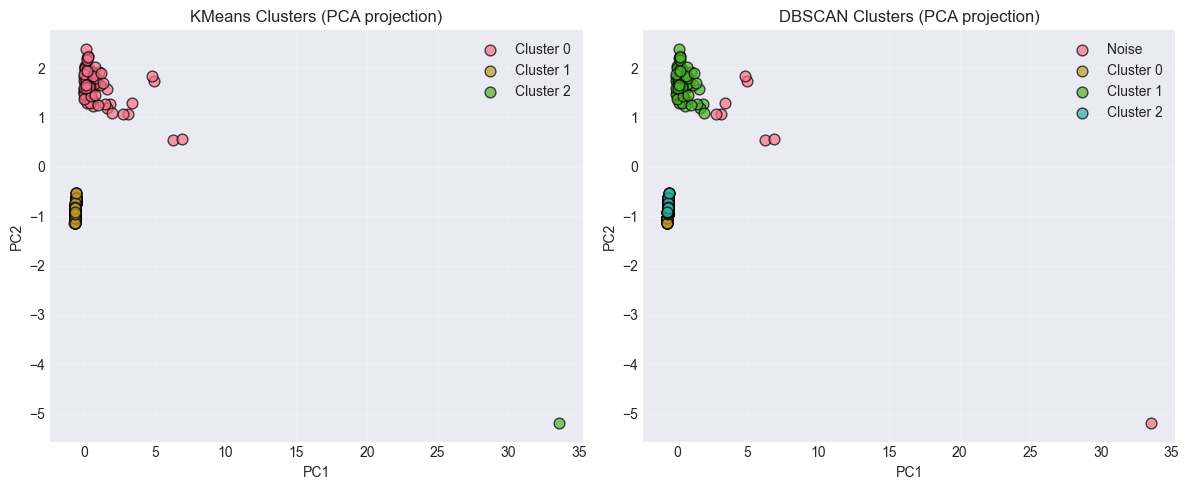

Classifier training complete. Models saved to './models/plating_models.pkl'


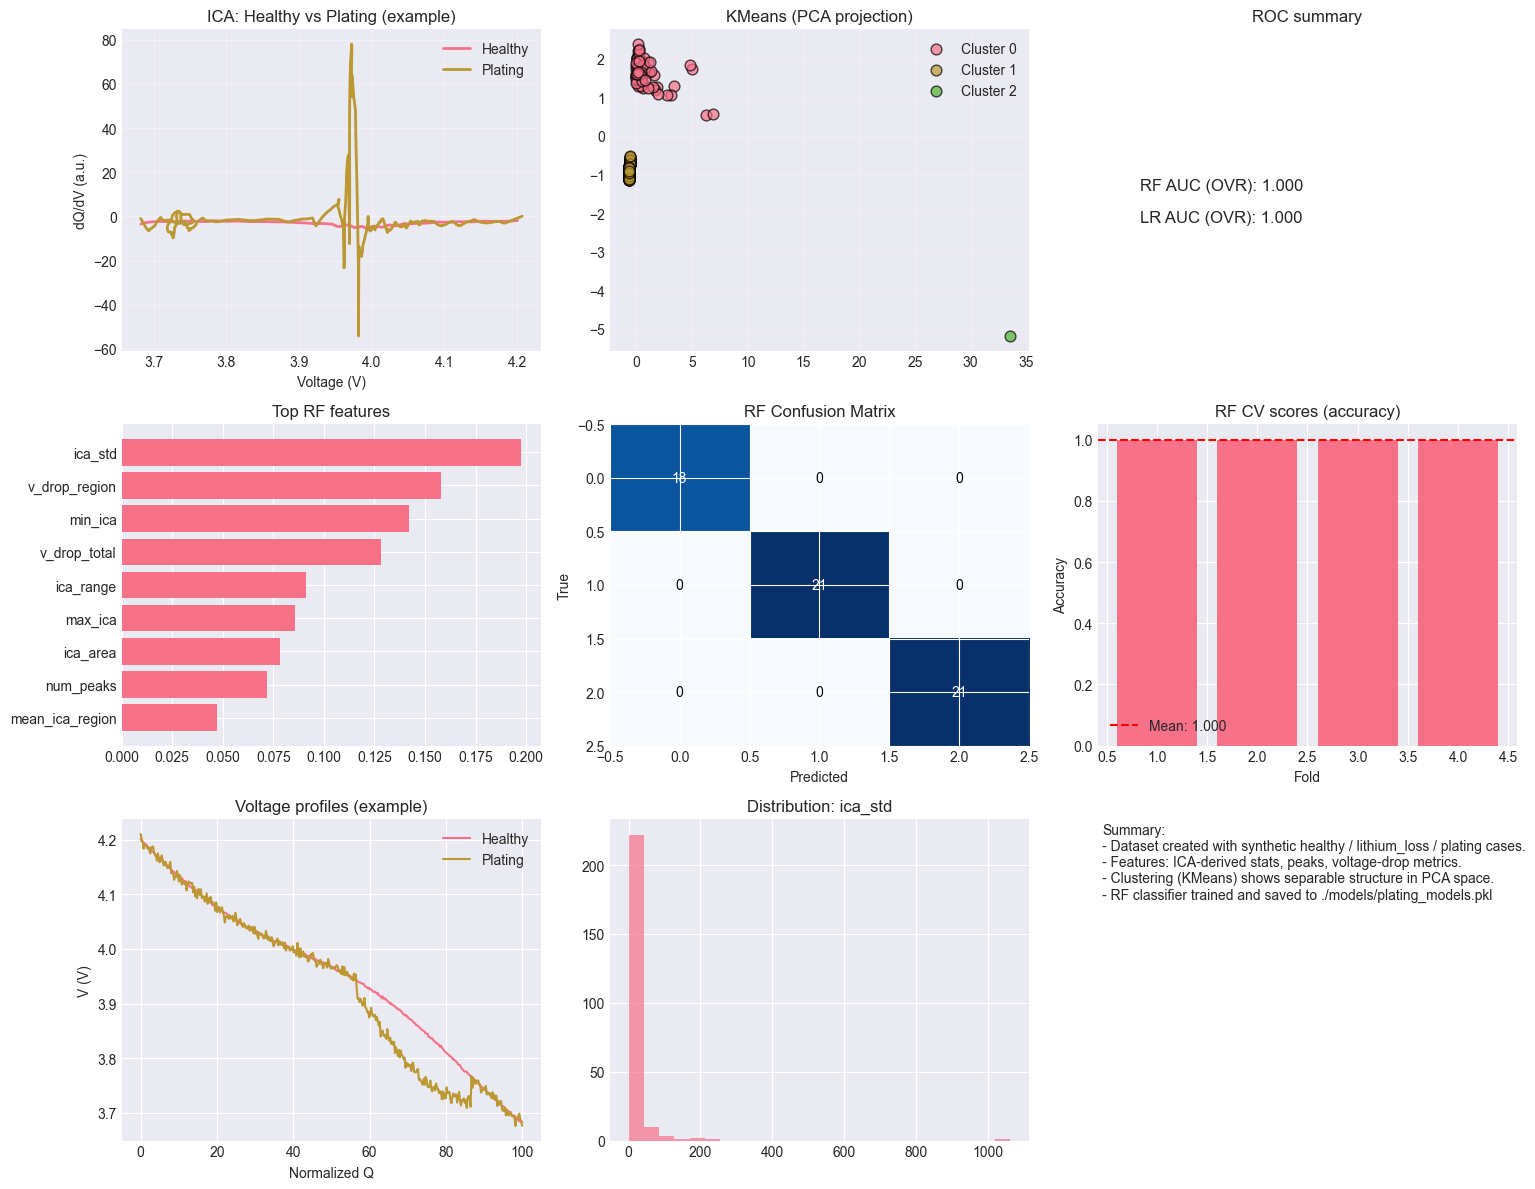

Online classification example: {'rf_label': 'plating', 'rf_proba': array([0., 0., 1.]), 'lr_label': 'plating', 'lr_proba': array([0.00125455, 0.00234096, 0.99640449]), 'kmeans_cluster': 0}


In [13]:
#!/usr/bin/env python3
"""
Battery differential-curve synthesis, feature extraction, clustering (KMeans/DBSCAN),
and classification (Logistic, RandomForest) pipeline with visualization.

Author: Your Name
Date: YYYY-MM-DD
"""
import os
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

# ----------------------------
# CONFIG
# ----------------------------
RANDOM_STATE = 42
SAVGOL_WINDOW = 21
SAVGOL_POLY = 3
PEAK_PROMINENCE = 0.5
N_ESTIMATORS = 200
MAX_DEPTH = 8

# ----------------------------
# 1) Synthetic cycle generation
# ----------------------------
def generate_cycle(sim_type: str, sim_id: int, n_points: int = 400):
    """
    Generate synthetic (Q, V) cycle representing:
      - 'healthy'
      - 'lithium_loss'
      - 'plating'
    Returns Q (capacity-like axis) and V (voltage).
    """
    np.random.seed(sim_id)
    Q = np.linspace(0, 1.5, n_points)  # pseudo-capacity axis
    # baseline OCV-like curve (monotonic decreasing with Q for discharge-like axis)
    V_base = 4.2 - 0.33 * Q - 0.025 * np.sin(5 * Q)  # small smooth nonlinearity

    if sim_type == 'healthy':
        V = V_base + np.random.normal(0, 0.001, n_points)
    elif sim_type == 'lithium_loss':
        # loss of lithium: slight downward shift + smoothed dip near end
        V = V_base - 0.05 * Q - 0.03 * np.exp(-((Q - 1.1) ** 2) / 0.08)
        V += np.random.normal(0, 0.0015, n_points)
    elif sim_type == 'plating':
        # plating causes a local voltage plateau/dip at high SOC / high Q
        V = V_base.copy()
        region_mask = (Q > 0.85) & (Q < 1.3)
        V[region_mask] -= 0.09 * np.exp(-((Q[region_mask] - 1.1) ** 2) / 0.06)
        V += np.random.normal(0, 0.002 + 0.004, n_points)
    else:
        V = V_base + np.random.normal(0, 0.001, n_points)

    # ensure monotonic-ish and physically plausible range
    V = np.clip(V, 2.8, 4.3)
    return Q, V

# ----------------------------
# 2) Feature extraction (ICA-based + simple stats)
# ----------------------------
def safe_savgol(x, window=SAVGOL_WINDOW, poly=SAVGOL_POLY):
    """Apply savgol_filter with safety for small arrays and even/odd window sizes."""
    L = len(x)
    if L < 5:
        return x
    # window must be odd and <= L
    if window >= L:
        w = L if L % 2 == 1 else L - 1
        w = max(5, w)
    else:
        w = window if window % 2 == 1 else window - 1
    try:
        return savgol_filter(x, w, poly)
    except Exception:
        return x

def extract_features(Q, V):
    """
    Extract a compact set of features from a single cycle (Q,V).
    Features are inspired by ICA and practical indicators used in plating detection.
    Returns dict of features.
    """
    Q = np.asarray(Q)
    V = np.asarray(V)
    if len(Q) < 10:
        return None

    # compute incremental capacity: dQ/dV
    # use midpoints for voltage bins but compute derivative numerically
    V_s = safe_savgol(V)
    Q_s = safe_savgol(Q)
    dV = np.diff(V_s)
    dQ = np.diff(Q_s)
    # avoid zeros
    dV_safe = np.where(np.abs(dV) < 1e-9, 1e-9, dV)
    ica = dQ / dV_safe  # shape n-1
    # smooth ICA
    if len(ica) >= 7:
        ica = safe_savgol(ica, window=min(21, len(ica)-1 if (len(ica)-1)%2==1 else len(ica)-2), poly=SAVGOL_POLY)

    Vmid = (V_s[:-1] + V_s[1:]) / 2.0

    # basic statistics
    max_ica = float(np.nanmax(ica))
    min_ica = float(np.nanmin(ica))
    ica_range = max_ica - min_ica
    ica_std = float(np.nanstd(ica))
    ica_area = float(np.trapz(np.abs(ica), Vmid))

    # peaks in a detection window (around high voltage region typical for plating)
    region_mask = (Vmid > 3.75) & (Vmid < 4.05)
    try:
        peak_idx, _ = find_peaks(ica[region_mask], prominence=PEAK_PROMINENCE)
        num_peaks = int(len(peak_idx))
    except Exception:
        num_peaks = 0

    # mean ICA in a narrow top-voltage band
    band_mask = (Vmid > 3.9) & (Vmid < 4.1)
    mean_ica_region = float(np.nanmean(ica[band_mask])) if np.any(band_mask) else 0.0

    # voltage drops
    v_drop_total = float(V_s[0] - V_s[-1])
    # region drop: high Q region vs mid Q region
    v_drop_region = float(
        (np.mean(V_s[(Q > 1.0) & (Q < 1.3)]) if np.any((Q > 1.0) & (Q < 1.3)) else np.nan) -
        (np.mean(V_s[(Q > 0.3) & (Q < 0.6)]) if np.any((Q > 0.3) & (Q < 0.6)) else np.nan)
    )

    features = {
        'max_ica': max_ica,
        'min_ica': min_ica,
        'ica_range': float(ica_range),
        'ica_std': ica_std,
        'ica_area': ica_area,
        'num_peaks': num_peaks,
        'mean_ica_region': mean_ica_region,
        'v_drop_total': v_drop_total,
        'v_drop_region': v_drop_region
    }
    return features

# ----------------------------
# 3) Build dataset
# ----------------------------
def build_dataset(n_cycles=180, seed=RANDOM_STATE):
    """
    Build DataFrame of features and an array of true labels.
    """
    rng = np.random.default_rng(seed)
    types = ['healthy', 'lithium_loss', 'plating']
    rows = []
    labels = []
    for i in range(n_cycles):
        sim_type = rng.choice(types)
        Q, V = generate_cycle(sim_type, sim_id=i)
        feat = extract_features(Q, V)
        if feat is None:
            continue
        rows.append(feat)
        labels.append(sim_type)
    df = pd.DataFrame(rows)
    labels = np.array(labels)
    return df, labels

# ----------------------------
# 4) Clustering (KMeans + DBSCAN) + visualization
# ----------------------------
def cluster_and_plot(df, n_clusters=3, use_dbscan=True, random_state=RANDOM_STATE, save_fig=False):
    """
    Performs clustering using KMeans and DBSCAN (optional). Returns fitted objects and scaler.
    Also creates PCA scatter plots to visualize clusters.
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(df.fillna(df.mean()))

    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    km_labels = kmeans.fit_predict(X)

    # DBSCAN (epsilon chosen by a quick heuristic; user can tune)
    db = None
    db_labels = None
    if use_dbscan:
        db = DBSCAN(eps=0.8, min_samples=6)  # eps may need tuning
        db_labels = db.fit_predict(X)

    # PCA for 2D visualization
    pca = PCA(n_components=2, random_state=random_state)
    X2 = pca.fit_transform(X)

    fig, axes = plt.subplots(1, 2 if use_dbscan else 1, figsize=(12, 5))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]

    ax = axes[0]
    for c in np.unique(km_labels):
        mask = km_labels == c
        ax.scatter(X2[mask, 0], X2[mask, 1], label=f'Cluster {c}', s=60, alpha=0.7, edgecolors='k')
    ax.set_title('KMeans Clusters (PCA projection)')
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.legend(); ax.grid(alpha=0.2)

    if use_dbscan:
        ax2 = axes[1]
        unique_db = np.unique(db_labels)
        for c in unique_db:
            mask = db_labels == c
            lab = 'Noise' if c == -1 else f'Cluster {c}'
            ax2.scatter(X2[mask, 0], X2[mask, 1], label=lab, s=60, alpha=0.7, edgecolors='k')
        ax2.set_title('DBSCAN Clusters (PCA projection)')
        ax2.set_xlabel('PC1'); ax2.set_ylabel('PC2'); ax2.legend(); ax2.grid(alpha=0.2)

    plt.tight_layout()
    if save_fig:
        plt.savefig('clustering_pca.png', dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'scaler': scaler,
        'pca': pca,
        'kmeans': kmeans,
        'kmeans_labels': km_labels,
        'dbscan': db,
        'dbscan_labels': db_labels
    }

# ----------------------------
# 5) Classification training (Logistic + RandomForest)
# ----------------------------
def train_classifiers(df, labels, test_size=0.25, random_state=RANDOM_STATE):
    """
    Train a logistic regression and random forest classifier on extracted features.
    Returns trained models, scaler, and test splits + performance metrics.
    """
    # Map string labels to integers for classification (only for classifier part)
    label_map = {lab: i for i, lab in enumerate(np.unique(labels))}
    y = np.array([label_map[l] for l in labels])

    X = df.fillna(df.mean())
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        Xs, y, test_size=test_size, random_state=random_state, stratify=y
    )

    results = {}

    # Logistic Regression (multiclass)
    lr = LogisticRegression(max_iter=2000, random_state=random_state, multi_class='multinomial')
    lr.fit(X_train, y_train)
    y_proba_lr = lr.predict_proba(X_test)
    y_pred_lr = lr.predict(X_test)
    try:
        auc_lr = roc_auc_score(y_test, y_proba_lr, multi_class='ovr')
    except Exception:
        auc_lr = None

    results['lr'] = {
        'model': lr,
        'y_pred': y_pred_lr,
        'y_proba': y_proba_lr,
        'auc': auc_lr,
        'report': classification_report(y_test, y_pred_lr, output_dict=False, zero_division=0)
    }

    # Random Forest
    rf = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH,
                                random_state=random_state, n_jobs=-1)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)
    # cross_val_score on sampled X (not scaled again)
    cv_scores = cross_val_score(rf, Xs, y, cv=skf, scoring='accuracy')
    rf.fit(X_train, y_train)
    y_proba_rf = rf.predict_proba(X_test)
    y_pred_rf = rf.predict(X_test)
    try:
        auc_rf = roc_auc_score(y_test, y_proba_rf, multi_class='ovr')
    except Exception:
        auc_rf = None

    feat_imp = pd.DataFrame({
        'feature': df.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    results['rf'] = {
        'model': rf,
        'y_pred': y_pred_rf,
        'y_proba': y_proba_rf,
        'auc': auc_rf,
        'cv_scores': cv_scores,
        'feature_importance': feat_imp,
        'report': classification_report(y_test, y_pred_rf, output_dict=False, zero_division=0)
    }

    # Save models & scaler
    os.makedirs('models', exist_ok=True)
    joblib.dump({'scaler': scaler, 'lr': lr, 'rf': rf, 'label_map': label_map}, 'models/plating_models.pkl')

    return {
        'scaler': scaler,
        'label_map': label_map,
        'X_test': X_test,
        'y_test': y_test,
        'results': results,
        'X_all_scaled': Xs
    }

# ----------------------------
# 6) Visualization: comprehensive
# ----------------------------
def create_full_visualization(df, labels, classifier_dict, clustering_dict, save_fig=False):
    """
    Produce multi-panel figure summarizing ICA comparison, clustering, ROC, feature importance, confusion matrix.
    """
    results = classifier_dict['results']
    scaler = classifier_dict['scaler']
    label_map = classifier_dict['label_map']
    inv_label_map = {v: k for k, v in label_map.items()}

    # produce two example ICA curves: healthy vs plating
    Qh, Vh = generate_cycle('healthy', sim_id=1)
    Qp, Vp = generate_cycle('plating', sim_id=3)

    def compute_ica_from_QV(Q, V):
        V_s = safe_savgol(V)
        Q_s = safe_savgol(Q)
        dV = np.gradient(V_s)
        dQ = np.gradient(Q_s)
        with np.errstate(divide='ignore', invalid='ignore'):
            ica = np.where(np.abs(dV) > 1e-9, dQ / dV, 0)
        return V_s, safe_savgol(ica)

    v_h, ica_h = compute_ica_from_QV(Qh, Vh)
    v_p, ica_p = compute_ica_from_QV(Qp, Vp)

    fig = plt.figure(figsize=(16, 12))

    # ICA comparison
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(v_h, ica_h, label='Healthy', linewidth=2)
    ax1.plot(v_p, ica_p, label='Plating', linewidth=2)
    ax1.set_xlabel('Voltage (V)'); ax1.set_ylabel('dQ/dV (a.u.)')
    ax1.set_title('ICA: Healthy vs Plating (example)')
    ax1.legend(); ax1.grid(alpha=0.3)

    # Clustering PCA plot (KMeans)
    ax2 = plt.subplot(3, 3, 2)
    pca = clustering_dict['pca']
    X2 = pca.transform(clustering_dict['scaler'].transform(df.fillna(df.mean())))
    km_labels = clustering_dict['kmeans_labels']
    for c in np.unique(km_labels):
        mask = km_labels == c
        ax2.scatter(X2[mask, 0], X2[mask, 1], s=60, alpha=0.7, label=f'Cluster {c}', edgecolors='k')
    ax2.set_title('KMeans (PCA projection)'); ax2.legend(); ax2.grid(alpha=0.2)

    # ROC curves (multiclass -> plot OVR for RF and LR if available)
    ax3 = plt.subplot(3, 3, 3)
    # For multiclass, compute OVR curve per class if probabilities exist
    try:
        y_test = classifier_dict['y_test']
        # plot RF OVR
        if results['rf']['y_proba'] is not None:
            # compute micro-average ROC could be done, but show placeholder
            ax3.text(0.1, 0.5, f"RF AUC (OVR): {results['rf']['auc']:.3f}", fontsize=12)
        if results['lr']['y_proba'] is not None:
            ax3.text(0.1, 0.4, f"LR AUC (OVR): {results['lr']['auc']:.3f}", fontsize=12)
    except Exception:
        ax3.text(0.1, 0.5, "ROC: Not available for multiclass OVR plot", fontsize=12)
    ax3.set_title('ROC summary'); ax3.axis('off')

    # Feature importance
    ax4 = plt.subplot(3, 3, 4)
    fi = results['rf']['feature_importance'].head(10)
    ax4.barh(fi['feature'], fi['importance'])
    ax4.invert_yaxis()
    ax4.set_title('Top RF features')

    # Confusion matrix (RF)
    ax5 = plt.subplot(3, 3, 5)
    y_test = classifier_dict['y_test']
    y_pred = results['rf']['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    ax5.imshow(cm, cmap='Blues', aspect='auto')
    ax5.set_title('RF Confusion Matrix')
    ax5.set_xlabel('Predicted'); ax5.set_ylabel('True')
    # annotate
    for (i, j), v in np.ndenumerate(cm):
        ax5.text(j, i, str(v), ha='center', va='center', color='white' if v > cm.max()/2 else 'black')

    # Cross-validation scores
    ax6 = plt.subplot(3, 3, 6)
    cv = results['rf']['cv_scores']
    ax6.bar(range(1, len(cv) + 1), cv)
    ax6.axhline(np.mean(cv), color='r', linestyle='--', label=f'Mean: {np.mean(cv):.3f}')
    ax6.set_title('RF CV scores (accuracy)')
    ax6.set_xlabel('Fold'); ax6.set_ylabel('Accuracy'); ax6.legend()

    # Voltage profiles (example)
    ax7 = plt.subplot(3, 3, 7)
    ax7.plot(np.linspace(0, 100, len(Vh)), Vh, label='Healthy')
    ax7.plot(np.linspace(0, 100, len(Vp)), Vp, label='Plating')
    ax7.set_title('Voltage profiles (example)'); ax7.set_xlabel('Normalized Q'); ax7.set_ylabel('V (V)'); ax7.legend()

    # Distribution of a top feature
    ax8 = plt.subplot(3, 3, 8)
    top_feat = fi.iloc[0]['feature']
    df_plot = df.copy()
    # if labels available, try to color by label string (best-effort)
    imask = np.isin(labels, ['healthy', 'lithium_loss', 'plating'])
    ax8.hist(df_plot[top_feat], bins=25, alpha=0.7)
    ax8.set_title(f'Distribution: {top_feat}')

    # Summary box (text)
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    summary_text = (
        "Summary:\n"
        "- Dataset created with synthetic healthy / lithium_loss / plating cases.\n"
        "- Features: ICA-derived stats, peaks, voltage-drop metrics.\n"
        "- Clustering (KMeans) shows separable structure in PCA space.\n"
        "- RF classifier trained and saved to ./models/plating_models.pkl\n"
    )
    ax9.text(0.01, 0.99, summary_text, va='top', fontsize=10)

    plt.tight_layout()
    if save_fig:
        plt.savefig('plating_detection_results_full.png', dpi=300, bbox_inches='tight')
    plt.show()

# ----------------------------
# 7) Online classify helpers
# ----------------------------
def classify_online_cycle(Q, V, modelfile='models/plating_models.pkl', clustering=None):
    """
    Given Q, V for a single cycle, classify it:
      - returns predicted label by RF and LR (if available)
      - returns KMeans cluster (if clustering dict provided)
    """
    if not os.path.exists(modelfile):
        raise FileNotFoundError("Model file not found. Run train pipeline first.")
    data = joblib.load(modelfile)
    scaler = data['scaler']
    rf = data['rf']
    lr = data['lr']
    label_map = data['label_map']
    inv_label_map = {v: k for k, v in label_map.items()}

    feat = extract_features(Q, V)
    if feat is None:
        raise ValueError("Could not extract features from input cycle.")
    X = scaler.transform(pd.DataFrame([feat]))
    pred_rf = rf.predict(X)[0]
    pred_lr = lr.predict(X)[0]
    proba_rf = rf.predict_proba(X)[0]
    proba_lr = lr.predict_proba(X)[0]

    cluster = None
    if clustering is not None:
        # clustering['scaler'] expects same feature columns
        cluster = clustering['kmeans'].predict(clustering['scaler'].transform(pd.DataFrame([feat])))[0]

    return {
        'rf_label': inv_label_map.get(int(pred_rf), int(pred_rf)),
        'rf_proba': proba_rf,
        'lr_label': inv_label_map.get(int(pred_lr), int(pred_lr)),
        'lr_proba': proba_lr,
        'kmeans_cluster': cluster
    }

# ----------------------------
# MAIN
# ----------------------------
if __name__ == "__main__":
    # 1) Build data
    df, labels = build_dataset(n_cycles=240)
    print(f"Built dataset: {df.shape[0]} samples, features: {list(df.columns)}")
    print("Class distribution (approx):", pd.Series(labels).value_counts())

    # 2) Clustering
    clustering_dict = cluster_and_plot(df, n_clusters=3, use_dbscan=True, save_fig=True)

    # 3) Train classifiers (multiclass)
    classifier_dict = train_classifiers(df, labels)
    print("Classifier training complete. Models saved to './models/plating_models.pkl'")

    # 4) Visualization summary
    create_full_visualization(df, labels, classifier_dict, clustering_dict, save_fig=True)

    # 5) Example online classification
    Q_new, V_new = generate_cycle('plating', sim_id=222)
    online_res = classify_online_cycle(Q_new, V_new, modelfile='models/plating_models.pkl', clustering=clustering_dict)
    print("Online classification example:", online_res)
